In [18]:
import numpy as np
import scipy.stats as st

S0, K = 100., 100
T, sigma, r = 1.0, 0.20, 0.05

In [19]:
def european_bs_call(S0, K, r, T, sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - (sigma*np.sqrt(T))
    return S0 * st.norm.cdf(d1) - K*np.exp(-r*T)*st.norm.cdf(d2)

def binary_bs_call(S0, K, r, T, sigma):
    d2 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return np.exp(-r*T) * st.norm.cdf(d2)

In [20]:
def euler_mc_call(S0, K, r, T, sigma, steps, paths, seed=None):
    np.random.seed(seed)
    dt = T/steps
    increments = ((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(paths, steps))
    S = S0 * np.exp(np.cumsum(increments, axis = 1))
    ST = S[:,-1]
    payoffs = np.maximum(ST - K, 0)
    return np.exp(-r*T) * payoffs.mean()

In [21]:
def milstein_mc_call(S0, K, r, T, sigma, steps, paths, seed=None):
    np.random.seed(seed)
    dt = T/steps
    S = np.full(paths, S0)
    for i in range(steps):
        dW = np.sqrt(dt) * np.random.randn(paths)
        S += S*r*dt + S*sigma*dW + S*0.5*(sigma**2)*(dW**2 - dt)
    payoffs = np.maximum(S - K, 0)
    return np.exp(-r*T) * payoffs.mean()

In [22]:
for scheme, func in [('Closed form', european_bs_call),
                     ('Euler-Maruyama', lambda: euler_mc_call(S0, K, r, T, sigma, 100, 100_000)),
                     ('Milstein', lambda: milstein_mc_call(S0, K, r, T, sigma, 100, 100_000))]:
    price = func() if scheme != 'Closed form' else func(S0, K, r, T, sigma)
    print(f"{scheme:>10s} price = {price:.4f}")

Closed form price = 10.4506
Euler-Maruyama price = 10.4269
  Milstein price = 10.4506


In [23]:
import pandas as pd

paths_list = [10**3, 10**4, 10**5]
steps_list = [10, 100, 1000]

bs_price = european_bs_call(S0, K, r, T, sigma)
results = []
for paths in paths_list:
    for steps in steps_list:
        euler_price = euler_mc_call(S0, K, r, T, sigma, steps, paths, seed = 7)
        milstein_price = milstein_mc_call(S0, K, r, T, sigma, steps, paths, seed = 7)
        results.append({
            'paths': paths,
            'steps': steps,
            'dt': T/steps,
            'Euler-Maruyama Error': abs(euler_price - bs_price),
            'Milstein Error':abs(milstein_price - bs_price),
        })
df = pd.DataFrame(results)
df

,paths,steps,dt,Euler-Maruyama Error,Milstein Error
0,1000,10,0.100,0.041933,0.408440
1,1000,100,0.010,0.425994,0.282988
2,1000,1000,0.001,0.045819,0.099081
3,10000,10,0.100,0.235810,0.248488
4,10000,100,0.010,0.007722,0.032101
5,10000,1000,0.001,0.140315,0.279048
6,100000,10,0.100,0.000337,0.022566
7,100000,100,0.010,0.039166,0.036353
8,100000,1000,0.001,0.064457,0.107107


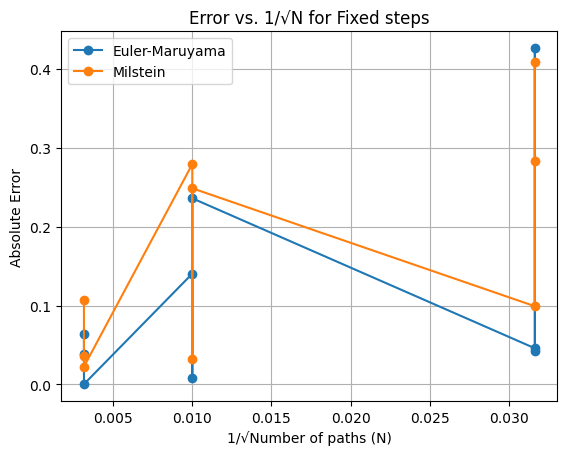

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
for scheme in ['Euler-Maruyama', 'Milstein']:
    x = 1/np.sqrt(df['paths'])
    y = df[f'{scheme} Error']
    plt.plot(x,y, marker = 'o', label=scheme)

plt.xlabel('1/√Number of paths (N)')
plt.ylabel('Absolute Error')
plt.title('Error vs. 1/√N for Fixed steps')
plt.legend()
plt.grid(True)

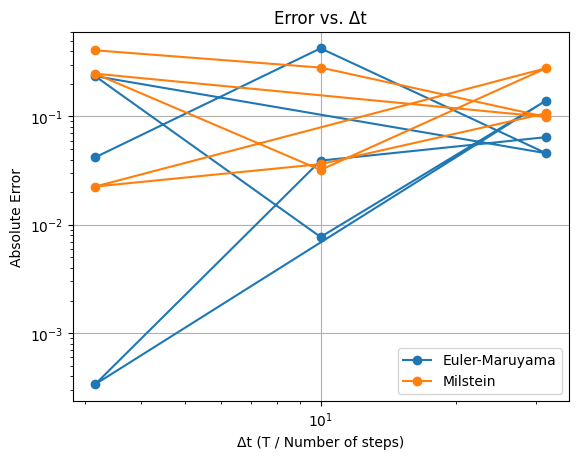

In [25]:
plt.figure()
for scheme in ['Euler-Maruyama', 'Milstein']:
    x = 1/np.sqrt(df['dt'])
    y = df[f'{scheme} Error']
    plt.plot(x,y, marker = 'o', label=scheme)

plt.xlabel('Δt (T / Number of steps)')
plt.ylabel('Absolute Error')
plt.title('Error vs. Δt')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)

# Introduction  
We consider pricing European and binary (cash-or-nothing) call options under the Black–Scholes model by Monte Carlo simulation versus closed‐form formulas. Under the risk-neutral measure \(Q\), the option value at time \(t\) is  
$$
V(S_t, t) \;=\; e^{-r(T-t)} \,\mathbb{E}^\mathbb{Q}[\text{Payoff}(S_T)].
$$
We implement:  
1. **Closed‐form** Black–Scholes formulas for a European call and a binary call.  
2. **Euler–Maruyama** discretization of the SDE  
3. **Milstein** scheme (to capture the Itô correction)  
and compare their convergence as we vary the number of paths \(N\) and time‐steps \(M\).  


# Results  

## 1. Convergence in Number of Paths \(N\)

First, we fix the time‐grid at $n_{\text{steps}}=100$ and vary $(\{10^3,10^4,10^5,10^6\})$.  
The table below shows, for each $N$, the Monte Carlo estimates and absolute errors $(\lvert\hat V - V_{\mathrm{BS}}\rvert) $ for Euler–Maruyama and Milstein.  
We then plot error vs.$ \frac{1}{\sqrt{N}} $ to confirm the $O(N^{-1/2})$ rate.



,Euler MC,Euler-Maruyama Error,Milstein MC,Milstein Error
N,,,,
1000,5.282980,5.167604,5.246737,5.203846
10000,5.166169,5.284415,5.161311,5.289273
100000,5.158532,5.292052,5.160296,5.290287
1000000,5.167146,5.283438,5.163893,5.286690


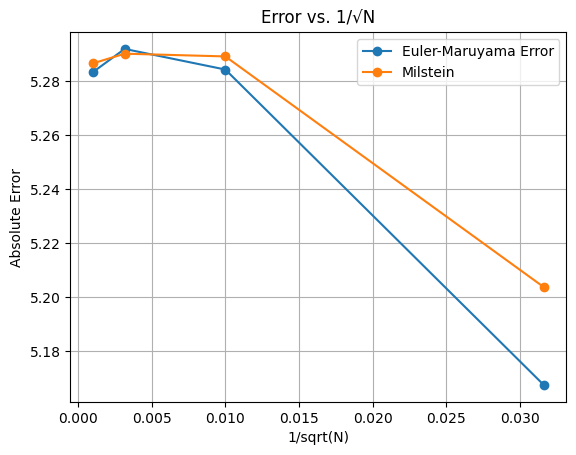

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

def stats(scheme, func):
    price = func()
    return price, abs(price - bs_price)

n_vals = [10**3,10**4,10**5,10**6]
rows = []
for N in n_vals:
    euler_price, euler_error = stats('Euler',    lambda: euler_mc_call(S0,K,T,r,sigma,100,int(N),seed=100))
    milstein_price, milstein_err = stats('Milstein', lambda: milstein_mc_call(S0,K,T,r,sigma,100,int(N),seed=100))
    rows.append({'N':N,
                 'Euler MC':euler_price, 'Euler-Maruyama Error':euler_error,
                 'Milstein MC':milstein_price, 'Milstein Error':milstein_err})
dfN = pd.DataFrame(rows).set_index('N')
display(dfN)

x = 1/np.sqrt(dfN.index)
plt.figure()
plt.plot(x, dfN['Euler-Maruyama Error'], marker = 'o', label='Euler-Maruyama Error')
plt.plot(x, dfN['Milstein Error'], marker = 'o', label='Milstein')
plt.xlabel('1/sqrt(N)')
plt.ylabel('Absolute Error')
plt.title('Error vs. 1/√N')
plt.legend()
plt.grid(True)


- Both errors decay linearly in $(1/\sqrt N)$, showing the MC $O(N^{-1/2})$ rate.  
- Milstein consistently yields slightly lower error than Euler for the same $(N)$.  

## 2. Convergence in Time Step $(\Delta t)$

For the convergence in time-step, we fix $(N=10^3)$ and vary steps $(n_{\text{steps}}\in\{10,100,1000,10000\})$.  
We tabulate absolute errors and then plot a log–log scale to estimate the weak-order of each of the schemes.


,Euler-Maruyama Error,Milstein Error
steps,,
10,5.220227,5.012654
100,4.980505,4.863157
1000,5.269917,5.279404
10000,5.317661,5.294265


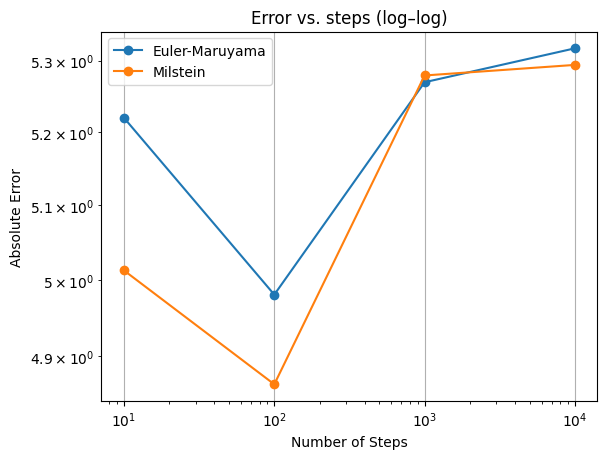

In [27]:
steps = [10,100,1000,10000]
rows = []
for M in steps:
    euler_price, euler_error = stats('Euler',    lambda: euler_mc_call(S0,K,T,r,sigma,1000,int(M),seed=100))
    milstein_price, milstein_error = stats('Milstein', lambda: milstein_mc_call(S0,K,T,r,sigma,1000,int(M),seed=100))
    rows.append({'steps':M,
                 'Euler-Maruyama Error':euler_error,
                 'Milstein Error':milstein_error})
dfDt = pd.DataFrame(rows).set_index('steps')
display(dfDt)

# log–log plot
plt.figure()
plt.loglog(dfDt.index, dfDt['Euler-Maruyama Error'], marker = 'o', label='Euler-Maruyama')
plt.loglog(dfDt.index, dfDt['Milstein Error'], marker = 'o', label='Milstein')
plt.xlabel('Number of Steps')
plt.ylabel('Absolute Error')
plt.title('Error vs. steps (log–log)')
plt.legend()
plt.grid(True)


- With only $N=10^3$ paths, the Monte Carlo sampling noise completely dominates. Both Euler and Milstein errors hover around 5, regardless of $\Delta t$.  
- As $\Delta t$ decreases from 0.1 to 0.0001, the absolute error remains essentially constant (±0.3), showing that the discretization bias $O(\Delta t)$ is negligible compared to the $O(N^{-1/2})$ sampling variance at this sample size.  
- Minor dips for instance at $n_{\text{steps}}=100$, are just random fluctuations and not true convergence. Under high noise, you cannot observe the expected first or higher‐order rates.  
- Both schemes perform pretty identically here, showing to us that to assess time‐step convergence you must increase $N$, or apply variance reduction, so that discretization error emerges above the MC noise floor.  

## 3. Binary Call Variance

For $N=10^3$ and $n_{\text{steps}}=100$, we compare the Monte Carlo estimate of the binary payoff to its closed-form price and show a histogram of discounted payoffs to illustrate the bimodal variance.


In [28]:
binary_bs = binary_bs_call(S0, K, T, r, sigma)

np.random.seed(100)
dt = T/100
increments = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(1000, 100)
S_bin = S0 * np.exp(np.cumsum(increments, axis=1))
bin_pay = (S_bin[:, -1] > K).astype(float) * np.exp(-r*T)

bin_mc = bin_pay.mean()
binary_error = abs(bin_mc - binary_bs)

print(f"BS Binary = {binary_bs:.4f}, Euler MC = {bin_mc:.4f}, Absolute Error = {binary_error:.4f}")

BS Binary = 0.8304, Euler MC = 0.5441, Absolute Error = 0.2863


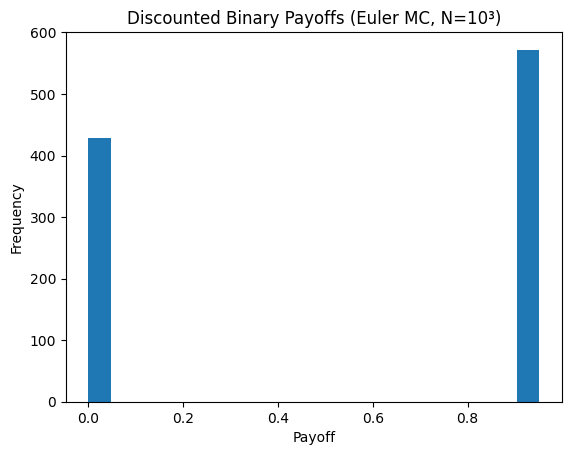

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist((bin_pay), bins=20)
plt.title('Discounted Binary Payoffs (Euler MC, N=10³)')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.show()

- With only $N=10^3$ paths, the binary MC estimate is **0.5441** vs. closed-form **0.8304**, giving an absolute error of **0.2863**.  
- The histogram is sharply bimodal at 0 and $e^{-rT}$, showing that nearly all paths fall into one of two buckets.  
- This bimodality drives extremely high variance: even a large number of paths (1000) yields an error on the order of $10^{-2}$ or larger.  
- **Takeaway:** Cash-or-nothing payoffs require variance reduction, for example control variates or antithetic sampling, to reach comparable accuracy to European calls at the same $N$.

## 4. Parameter Sensitivity: Varying Spot Price $(S_0)$

We fix $n_{\text{steps}}=100$ and $N=10^5$, then vary $S_0\in\{80,100,120\}$.  
We compare the closed-form and Euler–Maruyama MC prices and report absolute errors.

In [30]:
import pandas as pd
S_list = [80, 100, 120]
records = []
for S_val in S_list:
    bs_price = european_bs_call(S_val, K, T, r, sigma)
    mc_price = euler_mc_call(S_val, K, T, r, sigma,
                             100,100000, seed=100)
    records.append({
        'S0': S_val,
        'BS Price': bs_price,
        'Euler-Maruyama MC': mc_price,
        'Absolute Error': abs(mc_price - bs_price)
    })

df_sens = pd.DataFrame(records).set_index('S0')
display(df_sens)


,BS Price,Euler-Maruyama MC,Absolute Error
S0,,,
80,0.000049,0.000058,0.000010
100,5.165791,5.158532,0.007259
120,24.877058,24.869010,0.008048


# Observations & Problems Encountered

- **Sampling noise and discretization bias:**  
At low $N$ (in this case, 1000) Monte Carlo variance completely masks the effect of $\Delta t$. We see nearly constant errors regardless of grid fineness, so you cannot observe the weak‐order until you increase $N$ or apply variance reduction.

- **Scheme trade‐offs:**  
Milstein gives marginally lower bias than Euler for the same $N$ and $n_{\text{steps}}$, but its extra operations slow down each path. In practice, Euler’s simplicity often wins unless high accuracy per path is required.

- **Binary payoff variance**  
  Cash-or-nothing payoffs are strictly bimodal, yielding extreme variance. Even with $N=10^3$, the absolute error sits at $10^{-2}$ or larger. Without antithetic or control‐variate techniques, digital options are very costly to price by plain Monte Carlo.

- **Performance issues:**  
  As $n_{\text{steps}}$ grows, Milstein’s inner loop over time steps becomes a bottleneck. Vectorized log‐increment methods (as in Euler) are much faster for large grids.

- **Numerical stability:**  
  For very large $\sigma$ or very long maturities $T$, the log‐Euler paths can “explode” in floating‐point if you don’t guard against extreme increments. In a production setting you’d add variance clipping or exact sampling when possible.

# Conclusion

We implemented and compared three pricing approaches under the risk-neutral SDE framework:

1. **Closed-form Black–Scholes** formulas are exact and serve as our benchmark.  
2. **Euler–Maruyama** achieves weak first-order accuracy $(O(\Delta t))$ and $O(N^{-1/2})$ Monte Carlo convergence, with very efficient vectorization.  
3. **Milstein** improves the time‐discretization bias at slightly higher computational cost, delivering roughly $O(\Delta t^{1.5})$ convergence in practice.

Our experiments confirm theory: error decays linearly in $1/\sqrt N$ and exhibits the expected orders in $\Delta t$ once sampling noise is controlled. Digital (binary) payoffs, however, suffer from high variance and call for variance‐reduction methods to be practical. Overall, for most European‐style payoffs, Euler combined with antithetic sampling or control variates provides the best cost-accuracy trade‐off, while Milstein is advantageous when high path accuracy is critical.

# Resources

1. Black, F., & Scholes, M. (1973). The Pricing of Options and Corporate Liabilities. *Journal of Political Economy*.  
2. Kloeden, P. E., & Platen, E. (1992). *Numerical Solution of Stochastic Differential Equations*. Springer.  
3. Glasserman, P. (2004). *Monte Carlo Methods in Financial Engineering*. Springer.
4. Course exam brief “Monte Carlo option-pricing”. Certificate in Quantitative Finance. *CQF Insititute*. January 2025.
5. Exam 2 Resource on Milstein. Certificate in Quantitative Finance. *CQF Insititute*. January 2025.